In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from joblib import dump,load
from scipy.special import expit
from scipy.special import xlogy
from scipy.optimize import fmin_bfgs
from math import log

from sklearn.utils.validation import indexable
from sklearn.metrics import log_loss, make_scorer
from sklearn.isotonic import IsotonicRegression
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_val_predict
from sklearn.calibration import column_or_1d, calibration_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsRegressor, KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR

from catboost import CatBoostClassifier, CatBoostRegressor

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    
import warnings
warnings.filterwarnings(
    action='ignore',
)

In [3]:

class _SigmoidCalibration(RegressorMixin, BaseEstimator):
    """Sigmoid regression model.
    Attributes
    ----------
    a_ : float
        The slope.
    b_ : float
        The intercept.
    """

    def fit(self, X, y, sample_weight=None):
        """Fit the model using X, y as training data.
        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Training data.
        y : array-like of shape (n_samples,)
            Training target.
        sample_weight : array-like of shape (n_samples,), default=None
            Sample weights. If None, then samples are equally weighted.
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        X = column_or_1d(X)
        y = column_or_1d(y)
        X, y = indexable(X, y)

        self.a_, self.b_ = _sigmoid_calibration(X, y, sample_weight)
        return self

    def predict(self, T):
        """Predict new data by linear interpolation.
        Parameters
        ----------
        T : array-like of shape (n_samples,)
            Data to predict from.
        Returns
        -------
        T_ : ndarray of shape (n_samples,)
            The predicted data.
        """
        # T = column_or_1d(T)
        return expit(-(self.a_ * T + self.b_))


def _sigmoid_calibration(predictions, y, sample_weight=None):
    """Probability Calibration with sigmoid method (Platt 2000)
    Parameters
    ----------
    predictions : ndarray of shape (n_samples,)
        The decision function or predict proba for the samples.
    y : ndarray of shape (n_samples,)
        The targets.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights. If None, then samples are equally weighted.
    Returns
    -------
    a : float
        The slope.
    b : float
        The intercept.
    References
    ----------
    Platt, "Probabilistic Outputs for Support Vector Machines"
    """
    # predictions = column_or_1d(predictions)
    # y = column_or_1d(y)

    F = predictions  # F follows Platt's notations

    # Bayesian priors (see Platt end of section 2.2):
    # It corresponds to the number of samples, taking into account the
    # `sample_weight`.
    mask_negative_samples = y <= 0
    if sample_weight is not None:
        prior0 = (sample_weight[mask_negative_samples]).sum()
        prior1 = (sample_weight[~mask_negative_samples]).sum()
    else:
        prior0 = float(np.sum(mask_negative_samples))
        prior1 = y.shape[0] - prior0
    T = np.zeros_like(y, dtype=np.float64)
    T[y > 0] = (prior1 + 1.0) / (prior1 + 2.0)
    T[y <= 0] = 1.0 / (prior0 + 2.0)
    T1 = 1.0 - T

    def objective(AB):
        # From Platt (beginning of Section 2.2)
        P = expit(-(AB[0] * F + AB[1]))
        loss = -(xlogy(T, P) + xlogy(T1, 1.0 - P))
        if sample_weight is not None:
            return (sample_weight * loss).sum()
        else:
            return loss.sum()

    def grad(AB):
        # gradient of the objective function
        P = expit(-(AB[0] * F + AB[1]))
        TEP_minus_T1P = T - P
        if sample_weight is not None:
            TEP_minus_T1P *= sample_weight
        dA = np.dot(TEP_minus_T1P, F)
        dB = np.sum(TEP_minus_T1P)
        return np.array([dA, dB])

    AB0 = np.array([0.0, log((prior0 + 1.0) / (prior1 + 1.0))])
    AB_ = fmin_bfgs(objective, AB0, fprime=grad, disp=False)
    return AB_[0], AB_[1]

In [4]:
metadata = pd.read_csv('data/metadata.csv')
sup_metadata = pd.read_csv('data/supplemental_metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

In [5]:
train_50 = pd.read_csv('oof_/oof_train_50.csv')
test_50 = pd.read_csv('oof_/oof_test_50.csv')
train_50.shape, test_50.shape

((1059, 11), (804, 11))

In [6]:
print(log_loss(targets['basalt'], train_50['basalt']))

0.1352641494914019


In [7]:
bas = 'basalt'
io = "iron_oxide"
phy = 'phyllosilicate'

In [8]:
skf = StratifiedKFold(random_state=RANDOM_SEED,n_splits=20,shuffle=True)
rskf = RepeatedStratifiedKFold(n_splits=20,n_repeats=100,random_state=RANDOM_SEED)
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=False)

In [9]:
calib = _SigmoidCalibration()
calib.fit(train_50[bas],targets[bas])

_SigmoidCalibration()

In [10]:
calib.predict(test_50[bas])

0      0.018744
1      0.027265
2      0.999936
3      0.020038
4      0.019633
         ...   
799    0.036685
800    0.025246
801    0.018817
802    0.020031
803    0.095789
Name: basalt, Length: 804, dtype: float64

In [11]:
cv = cross_val_score(calib,train_50[bas],targets[bas],cv=rskf,scoring=log_loss_scorer)
cv.mean(), cv.std()

(-0.11984382848220254, 0.06223535225896785)

In [12]:
tot_loss = []
for i, (train_id,test_id) in enumerate(skf.split(train_50[bas],targets[bas])):
    train_50_ = train_50.iloc[train_id]
    test_50_ = train_50.iloc[test_id]
    calib.fit(train_50_[bas],targets[bas].iloc[train_id])
    preds = calib.predict(test_50_[bas])
    loss = log_loss(targets[bas].iloc[test_id],preds)
    # print(i,loss)
    tot_loss.append(loss)
print(np.array(tot_loss).mean())

0.11962449234819525


In [13]:
# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):
    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:
        y_col = y[col]  # take one label at a time
        X_col = X[col]
        log_loss_cv[col] = np.mean(
            cross_val_score(clf, X_col.values, y_col, cv=skf,scoring=log_loss_scorer))
    avg_log_loss = np.mean(list(log_loss_cv.values()))
    std_log_loss = np.std(list(log_loss_cv.values()))
    print('Average log loss: {}'.format(avg_log_loss))
    return log_loss_cv, avg_log_loss, std_log_loss

In [14]:
logloss_cross_val(calib,train_50,targets)

Average log loss: -0.13180907389875685


({'basalt': -0.11962449234819525,
  'carbonate': -0.10698640865213513,
  'chloride': -0.14295069535314314,
  'iron_oxide': -0.18055743873864755,
  'oxalate': -0.007585031776448882,
  'oxychlorine': -0.1473750928685112,
  'phyllosilicate': -0.19003568142311916,
  'silicate': -0.1746920522113929,
  'sulfate': -0.16353783070255207,
  'sulfide': -0.08474601491342323},
 -0.13180907389875685,
 0.05233547010451446)

In [15]:
cv = cross_val_score(calib,train_50[bas],targets[bas], cv=skf, scoring=log_loss_scorer)
-cv.mean()-cv.std(), -cv.mean(), -cv.mean()+cv.std()

(0.050432674433534636, 0.11962449234819525, 0.18881631026285586)

In [16]:
0.13493157515767454 > 0.11962449234819525

True

In [17]:
cv_preds = cross_val_predict(calib,train_50[bas],targets[bas],cv=skf)
cv_preds

array([0.02477712, 0.0185275 , 0.06173367, ..., 0.01717328, 0.02094265,
       0.02168105])

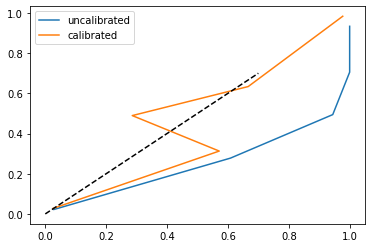

In [18]:
prob_true, prob_pred = calibration_curve(targets[bas], train_50[bas],strategy='uniform')
prob_true_1, prob_preds_1 = calibration_curve(targets[bas], cv_preds,strategy='uniform')
plt.plot(prob_true,prob_pred,label = 'uncalibrated')
plt.plot(prob_true_1,prob_preds_1,label='calibrated')
plt.plot([0,0.7],[0,0.7],'k--')
plt.legend()

In [19]:
prob_1 = targets[bas].sum()/len(targets[bas])
prob_1 = 1 - prob_1
prob_1

0.8847969782813976

In [20]:
sample_weight = np.ones_like(targets[bas])
sample_weight = np.where(targets[bas]==1, prob_1, 1 - prob_1)
sample_weight

array([0.11520302, 0.11520302, 0.11520302, ..., 0.11520302, 0.11520302,
       0.11520302])

In [21]:
iso = IsotonicRegression(y_max=0.95,y_min=0.01,out_of_bounds='clip')
iso_cv = cross_val_score(iso,train_50[bas],targets[bas],cv=rskf,scoring=log_loss_scorer)

In [22]:
-iso_cv.mean(), iso_cv.std()

(0.1223097178359193, 0.06124368601998579)

In [23]:
logloss_cross_val(iso,train_50,targets)

Average log loss: -0.1281700674627801


({'basalt': -0.12172061513303603,
  'carbonate': -0.09496921190852708,
  'chloride': -0.13935485285448548,
  'iron_oxide': -0.17561779220939824,
  'oxalate': -0.019394723345030396,
  'oxychlorine': -0.1317600018985851,
  'phyllosilicate': -0.19747350006878342,
  'silicate': -0.16488759865274286,
  'sulfate': -0.1641398840052941,
  'sulfide': -0.07238249455191795},
 -0.1281700674627801,
 0.05091410927337648)

In [24]:
# maybe calibrating these is a bad idea...

In [25]:
train_50 = pd.read_csv('oof_/oof_train_50.csv')
test_50 = pd.read_csv('oof_/oof_test_50.csv')

train_time_50 = pd.read_csv('oof_/oof_train_temp_50.csv')
test_time_50 = pd.read_csv('oof_/oof_test_temp_50.csv')

train_100 = pd.read_csv('oof_/oof_train_100.csv')
test_100 = pd.read_csv('oof_/oof_test_100.csv')

train_time_100 = pd.read_csv('oof_/oof_train_temp_100.csv')
test_time_100 = pd.read_csv('oof_/oof_test_temp_100.csv')

train_200 = pd.read_csv('oof_/oof_train_200.csv')
test_200 = pd.read_csv('oof_/oof_test_200.csv')

train_time_200 = pd.read_csv('oof_/oof_train_temp_200.csv')
test_time_200 = pd.read_csv('oof_/oof_test_temp_200.csv')


In [26]:
plt.rcParams['figure.figsize'] = (12,6)

In [27]:
train_files = [train_50,train_time_50,train_100,train_time_100,train_200,train_time_200]
test_files = [test_50,test_time_50,test_100,test_time_100,test_200,test_time_200]

train_file_names = ['train_50','train_time_50','train_100','train_time_100','train_200','train_time_200']
test_file_names = ['test_50','test_time_50','test_100','test_time_100','test_200','test_time_200']

In [28]:
targets.columns

Index(['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate',
       'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide'],
      dtype='object')

In [29]:
target = 'basalt'

In [30]:
def get_tar_df(target):
    tar_df = pd.DataFrame(columns = train_file_names)
    for i,train in enumerate(train_files):
        tar_df[train_file_names[i]] = train[target]
    return tar_df

In [50]:
def get_tar_df_test(target):
    tar_df = pd.DataFrame(columns = test_file_names)
    for i,train in enumerate(test_files):
        tar_df[test_file_names[i]] = train[target]
    return tar_df

<AxesSubplot:>

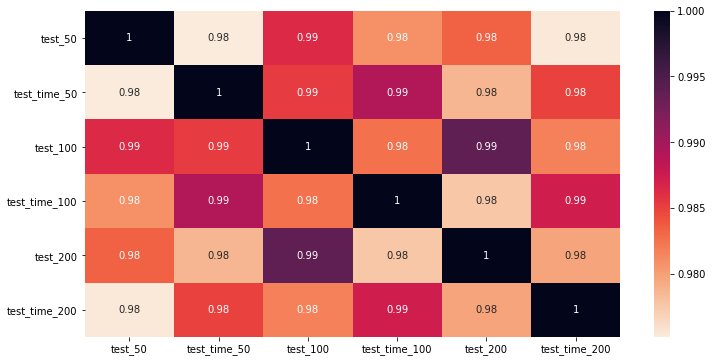

In [53]:
sns.heatmap(get_tar_df_test(target).corr(),annot=True,cmap='rocket_r')

<AxesSubplot:>

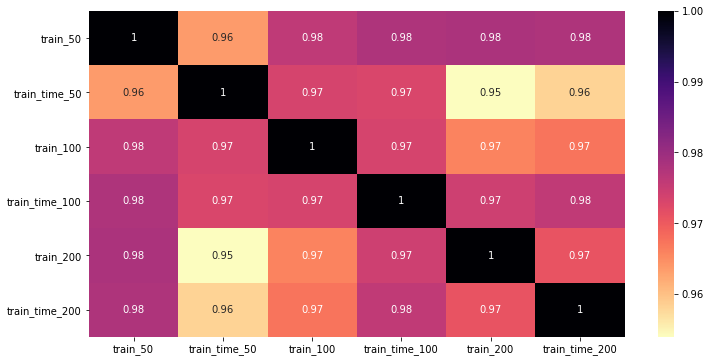

In [31]:
sns.heatmap(get_tar_df('basalt').corr(),annot=True,cmap='magma_r')

In [32]:
clf = CatBoostClassifier(verbose=False)

In [73]:
log_loss_scorer = make_scorer(log_loss,greater_is_better=False, needs_proba=False)

In [34]:
%%time
agg_loss = []
for target in targets.columns:
    print(target)
    tar_df = get_tar_df(target)
    calib_preds = np.zeros((tar_df.shape[0],tar_df.shape[1]))
    for i,col in enumerate(tar_df.columns):
        calib = _SigmoidCalibration()
        preds = cross_val_predict(calib,tar_df[col],targets[target],cv=skf)
        calib_preds[:,i] = preds
    cv = cross_val_score(clf,calib_preds,targets[target],cv=skf,scoring=log_loss_scorer)
    print(-cv.mean(),cv.std())
    agg_loss.append(-cv.mean())
print('agg loss:',np.array(agg_loss).mean())

basalt
0.12980351837749066 0.08827490274124304
carbonate
0.08341759512409103 0.07434784093756425
chloride
0.13630134429221058 0.10637324194218142
iron_oxide
0.18391150976863774 0.06730442082775667
oxalate
0.007781641912242234 0.020263184617718834
oxychlorine
0.12949837161506178 0.0886036101045427
phyllosilicate
0.19021371333843745 0.07726575280015728
silicate
0.1734391441546083 0.0887063762631961
sulfate
0.16677188178037966 0.09734424343509929
sulfide
0.0821994384172133 0.06626779330088867
agg loss: 0.12833381587803727


In [42]:
%%time
agg_loss = []
for target in targets.columns:
    print(target)
    tar_df = get_tar_df(target)
    calib_preds = np.zeros((tar_df.shape[0],tar_df.shape[1]))
    for i,col in enumerate(tar_df.columns):
        calib = _SigmoidCalibration()
        preds = cross_val_predict(calib,tar_df[col],targets[target],cv=skf)
        calib_preds[:,i] = preds

        # print(calib_preds)
    # cv = cross_val_score(clf,calib_preds,targets[target],cv=skf,scoring=log_loss_scorer)
    # print(-cv.mean(),cv.std())
    # agg_loss.append(-cv.mean())
print(log_loss(targets[target],calib_preds.mean(axis=1)))
# print('agg loss:',np.array(agg_loss).mean())

basalt
carbonate
chloride
iron_oxide
oxalate
oxychlorine
phyllosilicate
silicate
sulfate
sulfide
0.07581474076370877
Wall time: 3.72 s


In [36]:
for i, (train_id,test_id) in skf.split(tar_df,targets[target]):
    print(i)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for col in tar_df.columns:
        X = tar_df[col]
        calib = _SigmoidCalibration()
        X_train = X.iloc[train_id]
        X_test = X.iloc[test_id]
        y_train = targets[target].iloc[train_id]
        y_test = targets[target].iloc[test_id]
        calib.fit(X_train,y_train)
        preds = calib.predict(X_test)

        oof_train[test_id] = y_preds
        oof_test_skf[fold,:] = calib.predict(X_test.values)[:,1]

    calib_preds[test_id] = preds

array([0.04625068, 0.0463625 , 0.04633841, 0.04623735, 0.04645336,
       0.04640565])

In [38]:
a = np.array([[1,2,3],[4,5,6]])
a.mean(axis=1)

array([2., 5.])

In [39]:
a.shape

(2, 3)

In [70]:
# lr  0.3052962341440854
# lr  0.3239982196626524
# knn 0.5894523367682062/0.35634749615550243
# knn 0.35634749615550243
# rf 0.527098185929098/0.527098185929098
# svc 0.23970403199340756
# cb 0.12555419536242826

In [49]:
# average the predictions
tot_loss = []
for target in targets.columns:
    tar_df_avg = get_tar_df(target).mean(axis=1)
    loss = log_loss(targets[target],tar_df_avg)
    print(target, loss)
    tot_loss.append(loss)
print('agg_loss:',np.array(tot_loss).mean())

basalt 0.12944059009512446
carbonate 0.08364542405130632
chloride 0.14165062518401939
iron_oxide 0.18852733322713666
oxalate 0.004195500456769655
oxychlorine 0.1300305975179676
phyllosilicate 0.18962404078105488
silicate 0.16533412856218363
sulfate 0.15576284199089865
sulfide 0.06126346725818371
agg_loss: 0.1249474549124645


In [62]:
# average the predictions
tot_loss = []
df = pd.DataFrame(columns=targets.columns,index= train_100.index)
for target in targets.columns:
    tar_df_avg = get_tar_df(target).mean(axis=1)
    df[target] = tar_df_avg
    # loss = log_loss(targets[target],tar_df_avg_test)
    # print(target, loss)
    # tot_loss.append(loss)
# print('agg_loss:',np.array(tot_loss).mean())

In [66]:
# average the predictions
tot_loss = []
for target in targets.columns:
    tar_df_avg_test = get_tar_df_test(target).mean(axis=1)
    submission_format[target] = tar_df_avg_test
    # loss = log_loss(targets[target],tar_df_avg_test)
    # print(target, loss)
    # tot_loss.append(loss)
# print('agg_loss:',np.array(tot_loss).mean())

In [67]:
tot_loss = []
for tar in targets.columns:
    print(tar)
    loss = log_loss(val_labels[tar],submission_format[:293].drop('sample_id',axis=1)[tar])
    print(loss)
    tot_loss.append(loss)
print('agg_loss:',np.array(tot_loss).mean())

basalt
0.025260423445174335
carbonate
0.014948593671174808
chloride
0.031817053188323514
iron_oxide
0.056269076985415285
oxalate
0.0004982270342918026
oxychlorine
0.0243314308609783
phyllosilicate
0.04636228177469431
silicate
0.034479506224458896
sulfate
0.028582462563677583
sulfide
0.004958678811871422
agg_loss: 0.026750773456006023


In [69]:
submission_format.to_csv('submissions/avg_preds.csv',index=False)

In [ ]:
cb_clf = CatBoostClassifier(verbose=False,random_seed=RANDOM_SEED)

In [96]:
agg_loss = []
for target in targets.columns: 
    print(target)
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    tar_df = get_tar_df(target)
    test_tar_df = get_tar_df_test(target)
    X_test = test_tar_df
    cv_loss = []
    for fold, (train_id,test_id) in enumerate(skf.split(tar_df,targets[target])):
        X = tar_df.iloc[train_id]
        y = targets[target].iloc[train_id]
        X_val = tar_df.iloc[test_id]
        y_val = targets[target].iloc[test_id]

        cb_clf.fit(X,y)
        preds = cb_clf.predict_proba(X_val)[:,1]
        pred_loss = log_loss(y_val,preds)
        print(f'fold loss {fold}: ',pred_loss)
        cv_loss.append(pred_loss)

        oof_train[test_id] = preds
        oof_test_skf[fold,:] = cb_clf.predict_proba(X_test.values)[:,1]

        loss = np.array(cv_loss).mean()
        std = np.array(cv_loss).std()
    print(f'cv loss for {target}:',loss)
    print(f'cv std for {target}:',std)
    print('-----------------------------------------------------')
    agg_loss.append(loss)

    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_df[target] = oof_test
    oof_train_df[target] = oof_train
    print("=============================================================================")

print(np.array(agg_loss).mean())

basalt


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

fold loss 0:  0.11889924489742884
fold loss 1:  0.1715906085146575
fold loss 2:  0.07299240449609418
fold loss 3:  0.054773206772004764
fold loss 4:  0.03197460374852056
fold loss 5:  0.12714170694768653
fold loss 6:  0.1563996138627068
fold loss 7:  0.07010585495782817
fold loss 8:  0.1915561025086712
fold loss 9:  0.10587917729968462
fold loss 10:  0.09298151983424494
fold loss 11:  0.05260179184002491
fold loss 12:  0.19615768944019873
fold loss 13:  0.012466679518407107
fold loss 14:  0.0500980363652995
fold loss 15:  0.3879279649684213
fold loss 16:  0.2024173521677505
fold loss 17:  0.12723188119396087
fold loss 18:  0.2853124397355027
fold loss 19:  0.0832453147516212
cv loss for basalt: 0.12958765969103575
cv std for basalt: 0.08917783530034022
-----------------------------------------------------
carbonate
fold loss 0:  0.014330312999402368
fold loss 1:  0.07409627263192212
fold loss 2:  0.20870733763196536
fold loss 3:  0.12352240500337472
fold loss 4:  0.03940152232504708
fo

In [97]:
oof_train_df

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,NaN,0.003611,0.001755,0.007722,0.024148,0.000032,0.004228,0.127824,0.050391,0.943614,0.000055
1,NaN,0.001864,0.981521,0.002043,0.056500,0.000149,0.005858,0.008629,0.004390,0.018624,0.000084
2,NaN,0.049180,0.001246,0.008525,0.001503,0.000039,0.971591,0.028617,0.004296,0.012755,0.000118
3,NaN,0.031535,0.048991,0.006177,0.033933,0.000065,0.005090,0.003958,0.002708,0.887684,0.006394
4,NaN,0.001981,0.001098,0.013286,0.975912,0.000091,0.995968,0.911565,0.000788,0.011994,0.000137
...,...,...,...,...,...,...,...,...,...,...,...
1054,NaN,0.000768,0.001208,0.007287,0.001787,0.000057,0.004180,0.010216,0.170141,0.009838,0.000075
1055,NaN,0.004711,0.000480,0.007147,0.028450,0.000068,0.026348,0.010358,0.718225,0.002472,0.000046
1056,NaN,0.002182,0.000971,0.000967,0.002073,0.998896,0.004451,0.002688,0.000660,0.004988,0.000078
1057,NaN,0.003698,0.976715,0.009909,0.014316,0.000031,0.007116,0.030909,0.001399,0.015269,0.000084


In [98]:
def get_cal_tar_df(target):
    tar_df = get_tar_df(target)
    sig_cal = _SigmoidCalibration()
    cal_df = pd.DataFrame(columns=tar_df.columns,index=tar_df.index)
    for col in tar_df.columns:
        cv_preds = cross_val_predict(sig_cal,tar_df[col],targets[target],cv=skf)
        cal_df[col] = cv_preds
    return cal_df

In [102]:
get_tar_df('basalt').mean(axis=1)

0       0.014049
1       0.006449
2       0.070275
3       0.014067
4       0.004511
          ...   
1054    0.008114
1055    0.010747
1056    0.004204
1057    0.008556
1058    0.009203
Length: 1059, dtype: float64

In [105]:
log_loss(targets['basalt'],get_cal_tar_df('basalt').mean(axis=1))
# can this be trusted...........

0.11371960647741605

In [107]:
agg_loss = []
for tar in targets.columns:
    loss = log_loss(targets[tar],get_cal_tar_df(tar).mean(axis=1))
    agg_loss.append(loss)
    print(tar,loss)
print(np.array(agg_loss).mean())

basalt 0.11371960647741605
carbonate 0.09186352875168836
chloride 0.13854233311903216
iron_oxide 0.17899450712264148
oxalate 0.006679389658804797
oxychlorine 0.13219531163383963
phyllosilicate 0.18568571270054718
silicate 0.16869142852479768
sulfate 0.16109848210107122
sulfide 0.07581474076370877
0.12532850408535473


In [122]:
cal_list = {}
for target in targets.columns:
    print(target)
    tar_df = get_tar_df(target)
    test_df = get_tar_df_test(target)
    sig_cal = _SigmoidCalibration()
    cal_df = pd.DataFrame(columns=tar_df.columns,index=tar_df.index)
    cal_test_df = pd.DataFrame(columns=test_df.columns,index=test_df.index)
    for i in range(len(tar_df.columns)):
        cv_preds = cross_val_predict(sig_cal,tar_df.iloc[:,i],targets[target],cv=skf)
        cal_df.iloc[:,i] = cv_preds
        sig_cal.fit(tar_df.iloc[:,i],targets[target])
        test_col_preds = sig_cal.predict(test_df.iloc[:,0])
        cal_test_df.iloc[:,i] = test_col_preds
    cal_list[target] = cal_test_df

basalt
carbonate
chloride
iron_oxide
oxalate
oxychlorine
phyllosilicate
silicate
sulfate
sulfide


In [135]:
for tar in targets.columns:
    submission_format[tar] = cal_list[tar].mean(axis=1)

In [138]:
submission_format.to_csv('submissions/calb_avg_preds.csv',index=False)

In [131]:
oof_test_df.sample_id = metadata[metadata.split != 'train'].sample_id
oof_train_df.sample_id = metadata[metadata.split != 'test'].sample_id

In [134]:
# oof_test_df['sample_id'] = submission_format['sample_id']
oof_test_df.to_csv('submissions/cb_preds.csv',index=False)

In [126]:
for tar in targets.columns:
    submission_format[tar] = oof_test_df[tar]

In [127]:
submission_format

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,S0766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S0767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S0768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S0769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S0770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
799,S1565,0.001653,0.001499,0.011389,0.051463,0.000077,0.005921,0.008052,0.091713,0.002178,0.000223
800,S1566,0.001710,0.002062,0.019702,0.981612,0.000040,0.985512,0.049364,0.000779,0.002610,0.000072
801,S1567,0.003572,0.001285,0.988541,0.997656,0.000066,0.030486,0.993354,0.002665,0.001387,0.000053
802,S1568,0.001498,0.000872,0.000942,0.030787,0.000035,0.004857,0.004918,0.984616,0.002707,0.000139


In [ ]:
# calib_avg_preds = pd.read_csv('submissions/calb_avg_preds')  # 3rd
# cb_preds = pd.read_csv('submissions/cb_preds.csv')   # 2nd 
# avg_preds = pd.read_csv('submissions/avg_preds.csv')   # 1st